<a href="https://colab.research.google.com/github/Kat3473/star-tracker/blob/main/Polaris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Here is the following step-by-step workflow to train and implement the AI model onto the Arduino.


1.   Setup the Python environment on Colab
2.   Collect and upload the data
3.   Process the data through Colab
4.   Train & test the AI model on Colab
5.   Convert the model into TensorFlow Lite
6.   Encode the model as an Arduino header file and upload it onto the board



# Setup & Imports

Install the mediapipe library onto the Colab session. This will allow us to run object detection tasks directly on here. Perfrect for testing the model.

In [ ]:
!pip install mediapipe

Importing all neccessary libraries onto the drive:


*   Standard Python Libraries
*   TensorFlow and Keras
*   Libraries for image processing




In [20]:
#Import: General
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import pathlib
from PIL import Image
import matplotlib.pyplot as plt

#Import: Image Processing
from keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Import: ML model
import tensorflow as tf
import keras

#Import: Object Detection
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Dataset Construction

The images to train and test the model are grabbed directly from google drive to construct the correct datasets.

For this particular case, an image dataset of images of the night sky are being used. It is assumed that the brighest and only visible star in the night sky is Polaris.

In [2]:
#Defining dataset parameters
batch_size = 32 #Size of batches for the data
img_height = 224 #Height of the images
img_width = 224 #Width of the images

#Grabbing the images
dataset_url = "/content/drive/MyDrive/Star Tracker/Dataset" #google drive of the images
data_dir = pathlib.Path(dataset_url).with_suffix('') #sets up the directory to be used
classnames = ['polaris'] #Array to assign a label to the class

#Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir, #the directory being converted
  validation_split=0.2, #20% used for validation, 80% for actual training
  subset="training", #this is the training subset being outputted
  seed=132, #seed to randomise data order and seperation
  image_size=(img_height, img_width), #converts image sizes to required
  batch_size=batch_size, #the batch size of the dataset
  class_names=classnames, #assinging labels to the classes
  label_mode='int' #controls the datatype of the class labels i.e. [1, 0]
  )

#Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory( #same as above but for the validation dataset
  data_dir,
  validation_split=0.2,
  subset="validation", #for validation subset
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=classnames,
  label_mode='int'
  )


train_ds = train_ds.map(lambda images, labels:
                        (images, labels))
val_ds = val_ds.map(lambda images, labels:
                    (images, labels))


Found 61 files belonging to 1 classes.
Using 49 files for training.
Found 61 files belonging to 1 classes.
Using 12 files for validation.


# Model: Pre-trained

We'll be using transfer learning by building a much smaller 'model' onto the MobileNet neural network.

In [3]:
# Load the pre-trained model
model = keras.applications.MobileNetV3Small(
    input_shape=(img_height,img_width,3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
    name="MobileNetV3Small",
)

num_classes = len(classnames)
x = model.output
x = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.models.Model(inputs=model.input, outputs=x)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Training

In [ ]:
#Compiling the model
model.compile(
  optimizer='adamax', #using adamax optimizer
  loss=tf.keras.losses.SparseCategoricalCrossentropy(), #using sparce categorical crossentropy loss function
  metrics=[keras.metrics.SparseCategoricalAccuracy() #using accuracy (multi-class model version) and poisson metrics
          ]
)

#Training the model
score = model.fit(
  train_ds, #training dataset
  validation_data=val_ds, #validation dataset
  epochs=1, #number of training steps i.e. number of times the model is trained using the training dataset
).history #Recording the metrics into the array 'score'

In [ ]:
#Plotting Loss per epoch
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,1])
line1 = plt.plot(score["loss"], label='Training')
line2 = plt.plot(score["val_loss"], label='Validation')
plt.legend()

#Plotting Accuracy per epoch
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(score["sparse_categorical_accuracy"], label='Training')
plt.plot(score["val_sparse_categorical_accuracy"], label='Validation')
plt.legend()

print(score)

# Object Detection

The visualize function will allow us to visualize the results from the object detection test scenarios.



In [14]:
MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

Here we will implement the object detection features.

Note: This is still in progress and is currently using an imported TFLite model for testing.

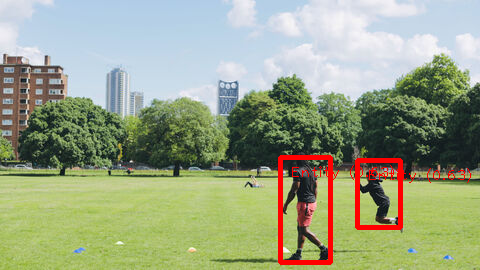

In [19]:
base_options = python.BaseOptions(model_asset_path='/content/drive/MyDrive/Star Tracker/Model/mobile_object_localizer_v1.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

image = mp.Image.create_from_file('/content/drive/MyDrive/Star Tracker/RS1695_AL4I4805_ad78662bc5c0b4a1f0fa41c3e05dc51c.jpg')

detection_result = detector.detect(image)

image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)